# Self-DACE Results

Name: Richard Zhao (Team: Richard Zhao, Oliver Fritsche, Yunpei Gu)

Class: CS 7180 Advanced Perception

Date: 2025-09-21

Purpose: Visualize qualitatively difference between model predictions using Oliver's `visualization_and_evaluation.ipynb`

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

from model import light_net
from data import ImageDataset
from evaluate import psnr, ssim, calculate_metrics

# Configuration - using LOL dataset
MODEL_PATH = "epoch_118_model.pth"
NO_ILLUM_MODEL_PATH = "no_ilum_epoch_61_model.pth"
LOW_DIR = "data/LOLdataset/eval15/low"
HIGH_DIR = "data/LOLdataset/eval15/high"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Low-light images: {LOW_DIR}")
print(f"Ground truth images: {HIGH_DIR}")

Using device: cuda
Low-light images: data/LOLdataset/eval15/low
Ground truth images: data/LOLdataset/eval15/high


In [2]:
# Load model and data
models = [light_net().to(DEVICE), light_net().to(DEVICE)]
models[0].load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
models[1].load_state_dict(torch.load(NO_ILLUM_MODEL_PATH, map_location=DEVICE))
models[0].eval()
models[1].eval()

# Load LOL dataset
low_dataset = ImageDataset(LOW_DIR, resize=(512, 512))
print(f"Model loaded. Low-light images: {len(low_dataset)}")


def tensor_to_img(tensor):
    if len(tensor.shape) == 4:
        tensor = tensor.squeeze(0)
    return tensor.cpu().clamp(0, 1).permute(1, 2, 0).numpy()


def load_ground_truth(low_img_path):
    """Load corresponding ground truth image"""
    # Get filename from low image path
    low_files = glob.glob(os.path.join(LOW_DIR, "*.png"))
    high_files = glob.glob(os.path.join(HIGH_DIR, "*.png"))

    # Find corresponding high image
    low_basename = os.path.basename(low_img_path).replace(".png", "")

    # Look for matching high image
    for high_file in high_files:
        high_basename = os.path.basename(high_file).replace(".png", "")
        if low_basename == high_basename:
            gt_img = Image.open(high_file).convert("RGB")
            gt_img = gt_img.resize((512, 512))
            gt_tensor = (
                torch.from_numpy(np.array(gt_img)).permute(2, 0, 1).float() / 255.0
            )
            return gt_tensor
    return None


# Test ground truth loading
low_files = glob.glob(os.path.join(LOW_DIR, "*.png"))
print(f"Found {len(low_files)} low-light images")
high_files = glob.glob(os.path.join(HIGH_DIR, "*.png"))
print(f"Found {len(high_files)} ground truth images")

[2025-09-22 14:38:17,657] [INFO] Found 15 images in data/LOLdataset/eval15/low


Model loaded. Low-light images: 15
Found 15 low-light images
Found 15 ground truth images



Processing 1.png...

Processing 778.png...


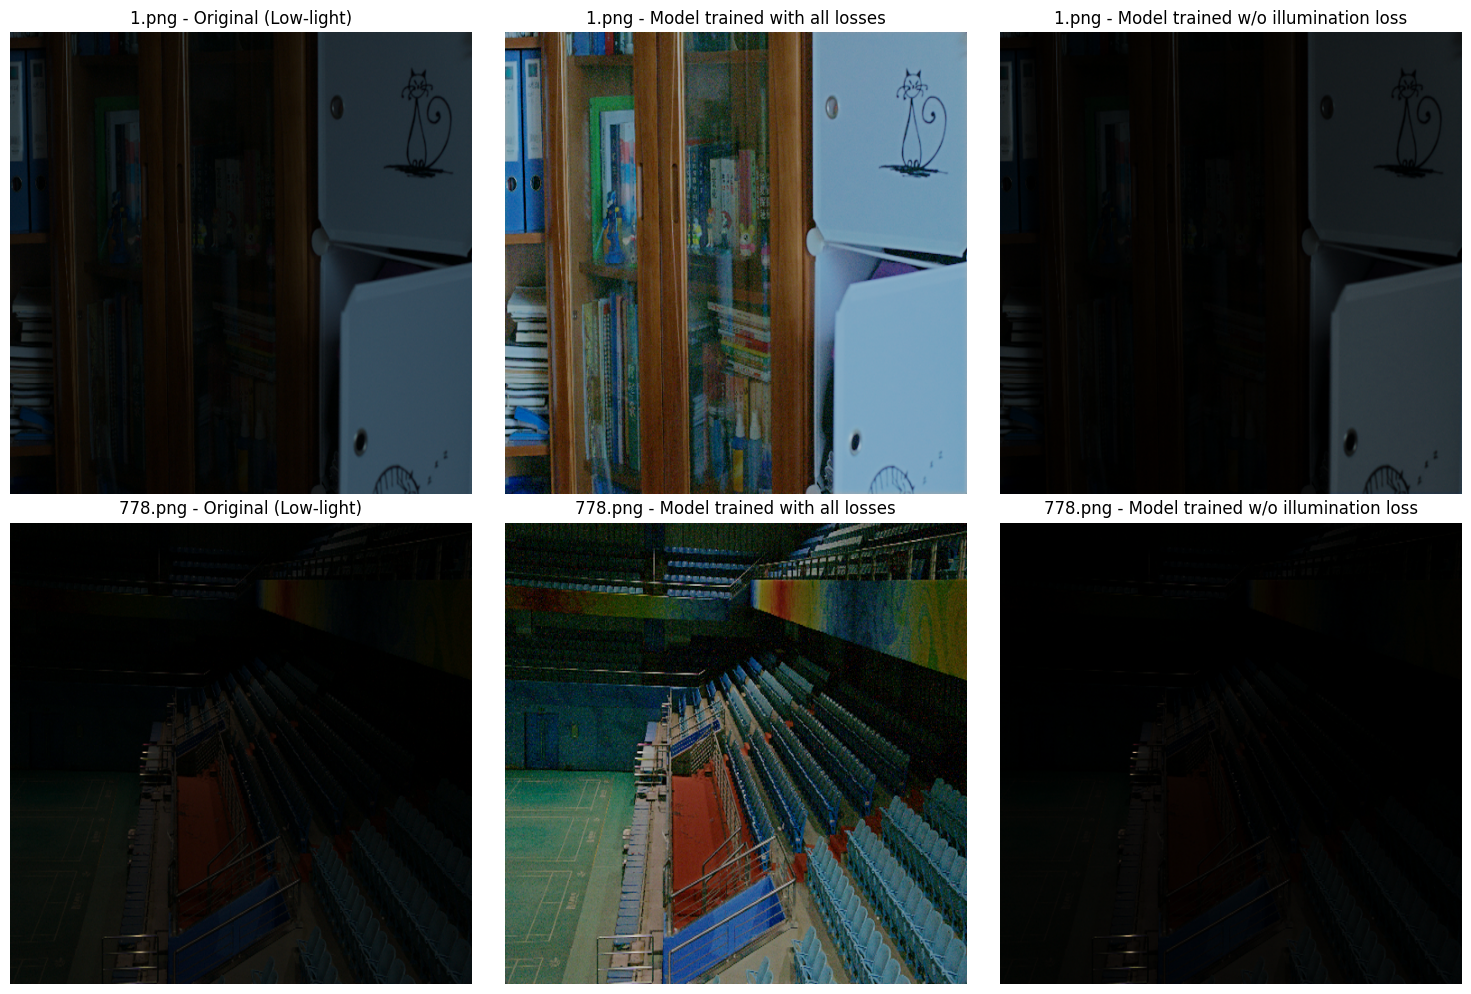

In [19]:
# LOL Dataset Comparison - Images 1 and 778 (as shown in paper)

# LOL dataset paths (using eval15 dataset)
lol_low_dir = "data/LOLdataset/eval15/low"
lol_high_dir = "data/LOLdataset/eval15/high"

# Specific images mentioned in paper for visual examples
target_images = ["1.png", "778.png"]

results = {}

for img_name in target_images:
    low_path = os.path.join(lol_low_dir, img_name)
    high_path = os.path.join(lol_high_dir, img_name)

    if os.path.exists(low_path) and os.path.exists(high_path):
        print(f"\nProcessing {img_name}...")

        # Load images
        low_img = Image.open(low_path).convert("RGB")
        high_img = Image.open(high_path).convert("RGB")

        # Resize to consistent size
        low_img = low_img.resize((512, 512))
        high_img = high_img.resize((512, 512))

        # Convert to tensor
        input_tensor = (
            torch.from_numpy(np.array(low_img)).permute(2, 0, 1).float() / 255.0
        )
        input_tensor = input_tensor.unsqueeze(0).to(DEVICE)

        # Enhance with model - unpack the tuple (enhanced, alphas, betas)
        enhanced_imgs = []
        with torch.no_grad():
            for i in range(len(models)):
                enhanced_tensor, _, _ = models[i](input_tensor, alpha_scale=0.7)

                # Convert back to PIL
                enhanced_np = enhanced_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
                enhanced_np = np.clip(enhanced_np, 0, 1)
                enhanced_imgs.append(
                    Image.fromarray((enhanced_np * 255).astype(np.uint8))
                )

        results[img_name] = {
            "low": low_img,
            "enhanced": enhanced_imgs[0],
            "no_ilum_enhanced": enhanced_imgs[1],
        }

# Create comparison visualization for paper images
if results:
    n_images = len(results)
    fig, axes = plt.subplots(n_images, 3, figsize=(15, 5 * n_images))

    # Handle single image case properly
    if n_images == 1:
        axes = axes.reshape(1, -1)

    for i, (img_name, data) in enumerate(results.items()):
        # Original (low-light)
        axes[i, 0].imshow(data["low"])
        axes[i, 0].set_title(f"{img_name} - Original (Low-light)")
        axes[i, 0].axis("off")

        # Our Enhancement
        axes[i, 1].imshow(data["enhanced"])
        axes[i, 1].set_title(f"{img_name} - Model trained with all losses")
        axes[i, 1].axis("off")

        # Ground Truth
        axes[i, 2].imshow(data["no_ilum_enhanced"])
        axes[i, 2].set_title(f"{img_name} - Model trained w/o illumination loss")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()
